In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import six
import numpy as np
from sklearn.datasets import fetch_mldata
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
import chainer.functions as F
import chainer.links as L

In [22]:
plt.style.use('ggplot')

In [23]:
batchsize = 100
n_epoch = 4
n_units = 1000

mnist = fetch_mldata('MNIST original')
mnist.data = mnist.data.astype(np.float32)
mnist.data /= 255

mnist.target = mnist.target.astype(np.int32)

In [24]:
N = 60000
x_train, x_test = np.split(mnist.data, [N])
y_train, y_test = np.split(mnist.target, [N])
N_test = y_test.size

In [25]:
class MLPModel(chainer.Chain):
    def __init__(self, n_in, n_units, n_out):
        super(MLPModel, self).__init__(
            l1 = L.Linear(n_in, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, n_out),
        )
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [26]:
mlp = MLPModel(784, n_units, 10)

In [27]:
model = L.Classifier(mlp)

In [28]:
optimizer = optimizers.Adam()
optimizer.setup(model)

In [42]:
test_accuracy = []
train_accuracy = []
for epoch in range(1, n_epoch + 1):
    print("epoch", epoch)
    
    perm = np.random.permutation(N)
    sum_accuracy = 0
    sum_loss = 0
    start = time.time()
    for i in range(0, N, batchsize):
        x = Variable(x_train[perm[i : i + batchsize]])
        t = Variable(y_train[perm[i : i + batchsize]])
        
        optimizer.update(model, x, t)
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
    
    end = time.time()
    elapsed_time = end - start
    throughput = N / elapsed_time
    train_accuracy.append(sum_accuracy / N)
    print('train mean loss={}, accuracy={}, throughput={} images/sec'.format(
        sum_loss / N, sum_accuracy / N, throughput))
    
    # 照合
    sum_accuracy = 0
    sum_loss = 0
    for i in range(0, N_test, batchsize):
        x = Variable(x_test[i : i + batchsize], volatile='on')
        t = Variable(y_test[i : i + batchsize], volatile='on')
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
    
    test_accuracy.append(sum_accuracy/N_test)
    print('test mean loss={}, accuracy={}'.format(
        sum_loss / N_test, sum_accuracy / N_test))

print('save the model')
serializers.save_npz('mlp.model', model)
print('save the optimizer')
serializers.save_npz('mlp.state', optimizer)


epoch 1
train mean loss=0.01709690570980759, accuracy=0.9945833384990692, throughput=1363.3174770228936 images/sec
test mean loss=0.08803424149994044, accuracy=0.9808000057935715
epoch 2
train mean loss=0.014054957290633562, accuracy=0.9956833372513453, throughput=1389.1311807986306 images/sec
test mean loss=0.09408636926516797, accuracy=0.9793000054359436
epoch 3
train mean loss=0.012565056826191115, accuracy=0.9960833369692167, throughput=1416.3982956972354 images/sec
test mean loss=0.09554304263956269, accuracy=0.9808000075817108
epoch 4
train mean loss=0.012985844011148705, accuracy=0.9960833370685578, throughput=1422.8558473661112 images/sec
test mean loss=0.08983004832065432, accuracy=0.981600005030632
save the model
save the optimizer


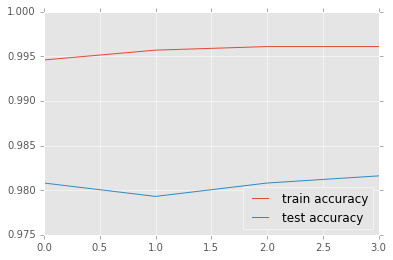

In [46]:
plt.plot(train_accuracy,label='train accuracy')
plt.plot(test_accuracy,label='test accuracy')
plt.legend(loc='lower right')